In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [97]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA', 'AMZN', 'AAPL']

df_sentiment_scores_dict = {}
df_stock_data_dict = {}
sentiment_scores = {}
stock_data = {}
stock_diff_close_open = {}

start_date = pd.to_datetime('2011-05-02').date()
end_date = pd.to_datetime('2019-12-23').date()

for symbol in stock_symbols:
    # Load sentiment and stock data
    df_sentiment_scores_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stock_news_sentiment_analysis_results_{symbol}.csv')
    df_stock_data_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stock_data_{symbol}.csv')

    # Convert date columns to datetime and extract date part only as `datetime.date`
    df_sentiment_scores_dict[symbol]['date'] = pd.to_datetime(df_sentiment_scores_dict[symbol]['date'], errors='coerce').dt.date
    df_stock_data_dict[symbol]['date'] = pd.to_datetime(df_stock_data_dict[symbol]['Date'], errors='coerce').dt.date
    
    # Filter sentiment scores based on date range
    mask_sentiment = (df_sentiment_scores_dict[symbol]['date'] >= start_date) & (df_sentiment_scores_dict[symbol]['date'] <= end_date)
    sentiment_scores[symbol] = df_sentiment_scores_dict[symbol][mask_sentiment]['weighted compound sentiment score']
    
    # Filter stock data based on date range and intersecting dates
    stock_dates = df_stock_data_dict[symbol]['date']
    mask_stock = (stock_dates >= start_date) & (stock_dates <= end_date) & (stock_dates.isin(df_sentiment_scores_dict[symbol]['date']))
    
    # Apply mask to filter stock data
    stock_data[symbol] = df_stock_data_dict[symbol][mask_stock]

    # Filter rows in stock data where dates match those in sentiment scores
    stock_data[symbol] = stock_data[symbol][stock_data[symbol]['date'].isin(df_sentiment_scores_dict[symbol]['date'])]
    stock_diff_close_open[symbol] =  stock_data[symbol]['Close']-stock_data[symbol]['Open']


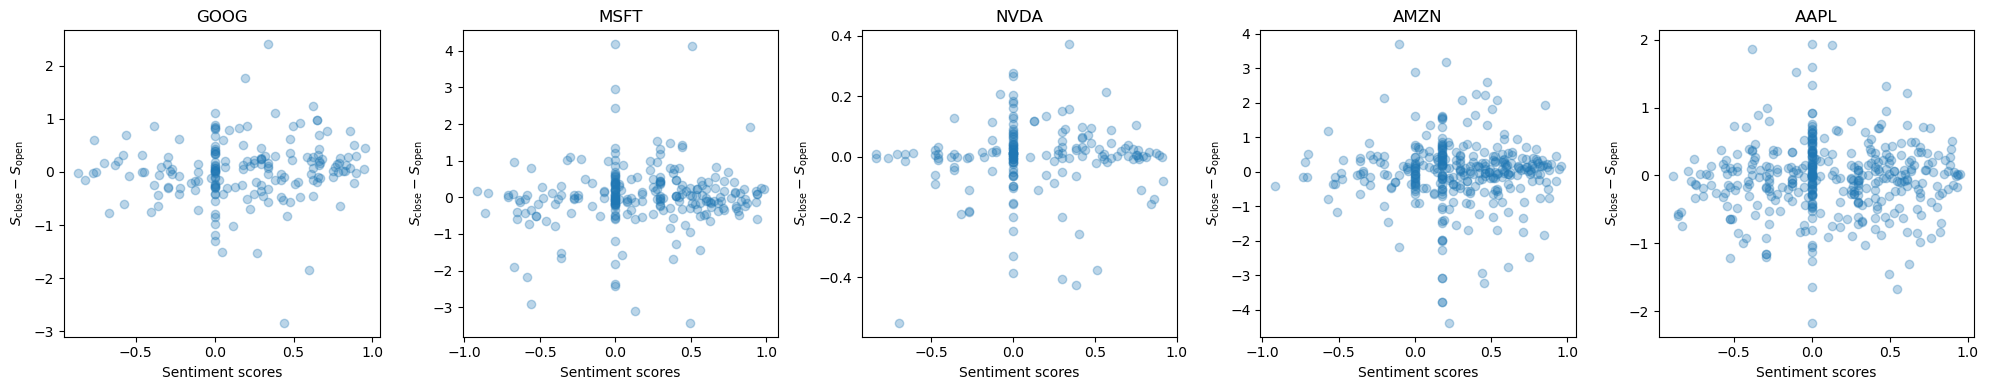

In [93]:
# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    axes[i].scatter(sentiment_scores[symbol],stock_diff_close_open[symbol],alpha = .3)
    axes[i].set_title(symbol)
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

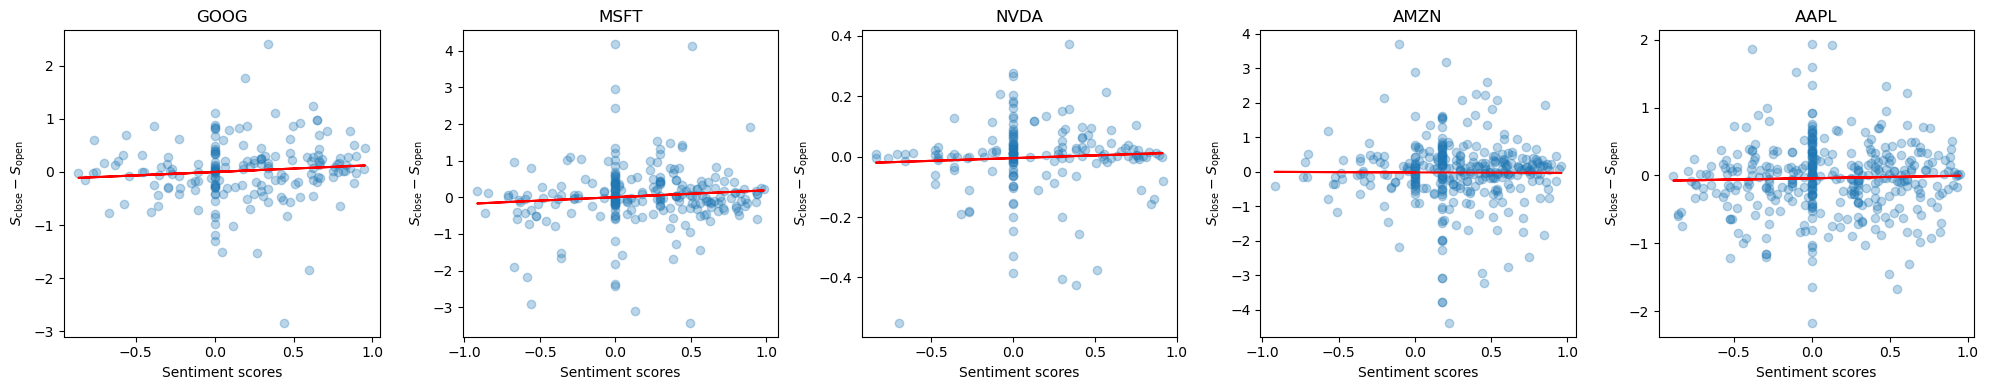

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
model = {}
mses = {}
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    # Reshape your data if needed
    X = np.array(sentiment_scores[symbol]).reshape(-1, 1)  # Sentiment scores as predictor
    y = np.array(stock_diff_close_open[symbol])

    model[symbol] = LinearRegression().fit(X, y)
    y_pred = model[symbol].predict(X)
    mses[symbol] = mse(y, y_pred)
    
    axes[i].scatter(sentiment_scores[symbol],stock_diff_close_open[symbol],alpha = .3)
    axes[i].plot(sentiment_scores[symbol],y_pred,color = "red")
    
    axes[i].set_title(symbol)
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [95]:
for symbol in stock_symbols:
    print([model[symbol].coef_,model[symbol].intercept_])

[array([0.12888167]), np.float64(0.0003029168563421676)]
[array([0.18675904]), np.float64(0.002996529901031421)]
[array([0.01798345]), np.float64(-0.0048615414661256785)]
[array([-0.01626487]), np.float64(-0.019142437823960662)]
[array([0.03844363]), np.float64(-0.04070536043943009)]


In [98]:
# Fit via statsmodel 
import statsmodels.api as sm

X_goog = np.array(sentiment_scores['GOOG'])
y_goog = np.array(stock_diff_close_open['GOOG'])

X_with_const = sm.add_constant(X_goog)

model_ols = sm.OLS(y_goog, X_with_const)
results = model_ols.fit()

# Print the summary to see coefficients and other statistics
print(results.summary())

# Get the confidence intervals for the coefficients
confidence_intervals = results.conf_int(alpha=0.05)  # 95% CI by default
print("Confidence intervals:\n", confidence_intervals)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.440
Date:                Sat, 02 Nov 2024   Prob (F-statistic):              0.120
Time:                        19:35:20   Log-Likelihood:                -160.54
No. Observations:                 185   AIC:                             325.1
Df Residuals:                     183   BIC:                             331.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0087      0.047     -0.184      0.8